### Generating human faces with Adversarial Networks (5 points)
<img src="https://www.strangerdimensions.com/wp-content/uploads/2013/11/reception-robot.jpg" width=320>
This time we'll train a neural net to generate plausible human faces in all their subtlty: appearance, expression, accessories, etc. 'Cuz when us machines gonna take over Earth, there won't be any more faces left. We want to preserve this data for future iterations. Yikes...

Based on Based on https://github.com/Lasagne/Recipes/pull/94 .


In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
plt.rcParams.update({'axes.titlesize': 'small'})

from sklearn.datasets import load_digits
#The following line fetches you two datasets: images, usable for autoencoder training and attributes.
#Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
from lfw_dataset import fetch_lfw_dataset
data,attrs = fetch_lfw_dataset(dimx=16,dimy=16)
data = data.transpose([0,3,1,2])

#preprocess faces
data = np.float32(data)/255.

IMG_SHAPE = (None,)+data.shape[1:]

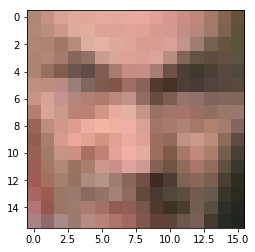

In [2]:
#print random image
plt.imshow(data[np.random.randint(data.shape[0])].transpose([1,2,0]), cmap="gray", interpolation="none")

# Generative adversarial nets 101

<img src="https://raw.githubusercontent.com/torch/torch.github.io/master/blog/_posts/images/model.png" width=320px height=240px>

Deep learning is simple, isn't it? 
* build some network that generates the face (small image)
* make up a __measure__ of __how good that face is__
* optimize with gradient descent :)


The only problem is: how can we engineers tell well-generated faces from bad? And i bet you we won't ask a designer for help. 

__If we can't tell good faces from bad, we delegate it to yet another neural network!__

That makes the two of them:
* __G__enerator - takes random noize for inspiration and tries to generate a face sample. 
  * Let's call him __G__(z), where z is a gaussian noize.
* __D__iscriminator - takes a face sample and tries to tell if it's great or fake. 
  * Predicts the probability of input image being a __real face__
  * Let's call him __D__(x), x being an image.
  * __D(x)__ is a predition for real image and __D(G(z))__ is prediction for the face made by generator.

Before we dive into training them, let's construct the two networks.

In [3]:
import theano, theano.tensor as T
theano.config.floatX='float32'
import lasagne, lasagne.layers as L

In [7]:
CODE_SIZE = 256

gen_input = L.InputLayer([None,CODE_SIZE])

gen = L.DenseLayer(gen_input,10*8*8,nonlinearity = T.nnet.elu)

gen = L.ReshapeLayer(gen,(-1,10,8,8))
gen = L.Deconv2DLayer(gen,64,filter_size=5,nonlinearity = T.nnet.elu)
gen = L.Deconv2DLayer(gen,64,filter_size=5,nonlinearity = T.nnet.elu)
#TODO uncomment for final attempt
#gen = L.Upscale2DLayer(gen,2)
#gen = L.Deconv2DLayer(gen,32,filter_size=3,nonlinearity = T.nnet.elu)
#gen = L.Deconv2DLayer(gen,32,filter_size=3,nonlinearity = T.nnet.elu)
gen = L.Deconv2DLayer(gen,32,filter_size=3,nonlinearity = T.nnet.elu)

gen = L.Conv2DLayer(gen,3,filter_size=3,nonlinearity=None)

In [8]:
assert gen.output_shape[1:] == IMG_SHAPE[1:], "generator must output an image of shape %s, but instead it produces %s"%(IMG_SHAPE[1:],gen.output_shape[1:])

### Discriminator
* Discriminator is your usual convolutional network with interlooping convolution and pooling layers
* The network does not include dropout/batchnorm to avoid learning complications.
* We also regularize the pre-output layer to prevent discriminator from being too certain.

__Note__ for those who look at both TF and theano: in Theano, we don't need to explicitly compute log_softmax because theano optimizes log(softmax(x)) for us.

In [9]:
disc_input = L.InputLayer(IMG_SHAPE)

#<build a convolutional neural net for discriminator>

disc_conv1 = L.Conv2DLayer(disc_input, num_filters=10, filter_size = (3, 3))

disc_pool1 = L.Pool2DLayer(disc_conv1, pool_size=2)

#disc_norm1 = L.BatchNormLayer(disc_pool1)

# disc_conv2 = L.Conv2DLayer(disc_pool1, num_filters=10, filter_size = (3, 3))

# disc_pool2 = L.Pool2DLayer(disc_conv2, pool_size=2)

# #disc_norm2 = L.BatchNormLayer(disc_pool2)

# disc_conv3 = L.Conv2DLayer(disc_pool2, num_filters=10, filter_size = (3, 3))

# disc_pool3 = L.Pool2DLayer(disc_conv3, pool_size=2)

#disc_norm3 = L.BatchNormLayer(disc_pool3)


disc = L.DenseLayer(disc_pool1,2,nonlinearity=T.nnet.softmax)

# Training

We train the two networks concurrently:
* Train __discriminator__ to better distinguish real data from __current__ generator
* Train __generator__ to make discriminator think generator is real
* Since discriminator is a differentiable neural network, we train both with gradient descent.

![img](https://s24.postimg.org/cw4nognxx/gan.png)

Training is done iteratively until discriminator is no longer able to find the difference (or until you run out of patience).


### Tricks:
* Regularize discriminator output weights to prevent explosion
* Train generator with __adam__ to speed up training. Discriminator trains with SGD to avoid problems with momentum.
* More: https://github.com/soumith/ganhacks


In [10]:
noise = T.matrix("noise")
real_data = T.tensor4("data images")

p_real = L.get_output(disc,{disc_input:real_data})

generated_data = L.get_output(gen, {gen_input : noise})

p_gen = L.get_output(disc, {disc_input : generated_data})


In [11]:
########################
#discriminator training#
########################

#                      P(real|X)           #P(fake|G(z))
d_loss = -T.mean(T.log(p_real)[:,1] + T.log(p_gen)[:,0])

#regularize final layer
d_loss += T.mean(disc.W**2)

#optimize
disc_updates = lasagne.updates.sgd(d_loss,L.get_all_params(disc),learning_rate=0.001)
train_disc = theano.function([real_data,noise],d_loss,updates=disc_updates,
                             allow_input_downcast=True)

In [12]:
########################
###generator training###
########################

g_loss = -T.mean(T.log(p_gen)[:,1])
#<generator loss: - log P(real|G(z))>

gen_updates = lasagne.updates.adam(g_loss,L.get_all_params(gen))

train_gen = theano.function([noise],g_loss,updates=gen_updates,
                            allow_input_downcast=True)

In [13]:
discriminate = theano.function([real_data],p_real,allow_input_downcast=True)
generate = theano.function([noise],generated_data,allow_input_downcast=True)

### Auxilary functions
Here we define a few helper functions that draw current data distributions and sample training batches.

In [14]:
def sample_noise_batch(bsize):
    return np.random.normal(size=(bsize, CODE_SIZE)).astype('float32')

def sample_data_batch(bsize):
    idxs = np.random.choice(np.arange(data.shape[0]), size=bsize)
    return data[idxs]

def sample_images(nrow,ncol, sharp=False):
    images = generate(sample_noise_batch(bsize=nrow*ncol))
    if np.var(images)!=0:
        images = images.clip(np.min(data),np.max(data))
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(images[i].reshape(IMG_SHAPE[1:]).transpose([1,2,0]),cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i].reshape(IMG_SHAPE[1:]).transpose([1,2,0]),cmap="gray")
    plt.show()

def sample_probas(bsize):
    plt.title('Generated vs real data')
    plt.hist(discriminate(sample_data_batch(bsize))[:,1],
             label='D(x)', alpha=0.5,range=[0,1])
    plt.hist(discriminate(generate(sample_noise_batch(bsize)))[:,1],
             label='D(G(z))',alpha=0.5,range=[0,1])
    plt.legend(loc='best')
    plt.show()

### Training
Main loop.
We just train generator and discriminator in a loop and draw results once every N iterations.

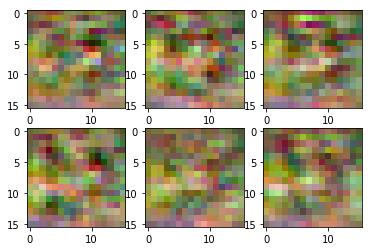

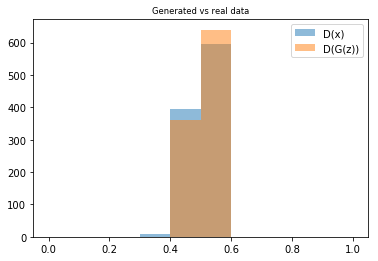

  0%|          | 205/50000 [01:45<7:06:18,  1.95it/s]

KeyboardInterrupt: 

In [15]:
from IPython import display
from tqdm import trange

for epoch in trange(50000):
    bx = sample_data_batch(32)
    bz = sample_noise_batch(32)
    
    for i in range(5):
        train_disc(bx,bz)
    
    train_gen(bz)
    
    if (epoch+1) %100==0:
        display.clear_output(wait=True)
        sample_images(2,3,True)
        sample_probas(1000)
        

In [ ]:
#The network was trained for about 15k iterations. 
#Training for longer yields MUCH better results
plt.figure(figsize=[16,24])
sample_images(16,8)